In [26]:
# importing the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# loading in parameters
s=0.25
n=0.03
alpha=0.33
delta=0.03
g=0.023
L_0 = 45
K_0 = 1035000
A_0 = 9900

# initialize the dataframe
df_base = pd.DataFrame({
    'Year':list(range(2022,2103,1))})


# initialize empty list to store the L vals
pop_list=[]

# iterate over the index, create values of L
for i, row in df_base.iterrows():
    if i == 0:
        pop_list.append(L_0)
    else: 
        pop_list.append(pop_list[i-1] * np.exp(n))

# create the column 
df_base['L'] = pop_list


In [28]:
# scenario 1

# technology addition

# initialize empty list to store the A vals
A_list_1=[]

# iterate over the index, create values of L
for i, row in df_base.iterrows():
    if i == 0:
        A_list_1.append(A_0)
    else: 
        A_list_1.append(A_list_1[i-1] * np.exp(g))

# create the scenario dataframe and the A column 
scen_1 = df_base.copy()
scen_1['A'] = A_list_1

# defining the capital accumulation function

def capital_accum(df,A_name):
#   defining some lists
    output_list = []
    capital_list = []
    Y_0 = (K_0**alpha)*((A_0 * L_0))**(1-alpha)
    
    # setting up the otput calculation
    for i,r in df.iterrows():
    
        if i == 0:
            output_list.append(Y_0)
            capital_list.append(K_0)
    
        else:
            capital_list.append(s*output_list[i-1] + (1-delta)*capital_list[i-1])
            output_list.append((capital_list[i]**alpha)*(df[A_name][i]*df['L'][i])**(1-alpha))
    
    
    df['K']= capital_list
    df['Y']=output_list
    return 

# defining a function that creates the columns of interests
def cols_of_interest(df, A_col, Y_col, K_col,y_col,y_tilde_col,k_tilde_col, opt=0):
    df[y_col] = df[Y_col] / df['L']
    if opt==1:
        df[y_tilde_col] = df[Y_col] / (df[A_col] * df['L'])
        df[k_tilde_col] = df[K_col] / (df[A_col] * df['L'])
    else: 
        pass
    return

def growth_rate(df, y_col, growth_col):
    df[growth_col] = (df[y_col] - df[y_col].shift(1))/df[y_col].shift(1)


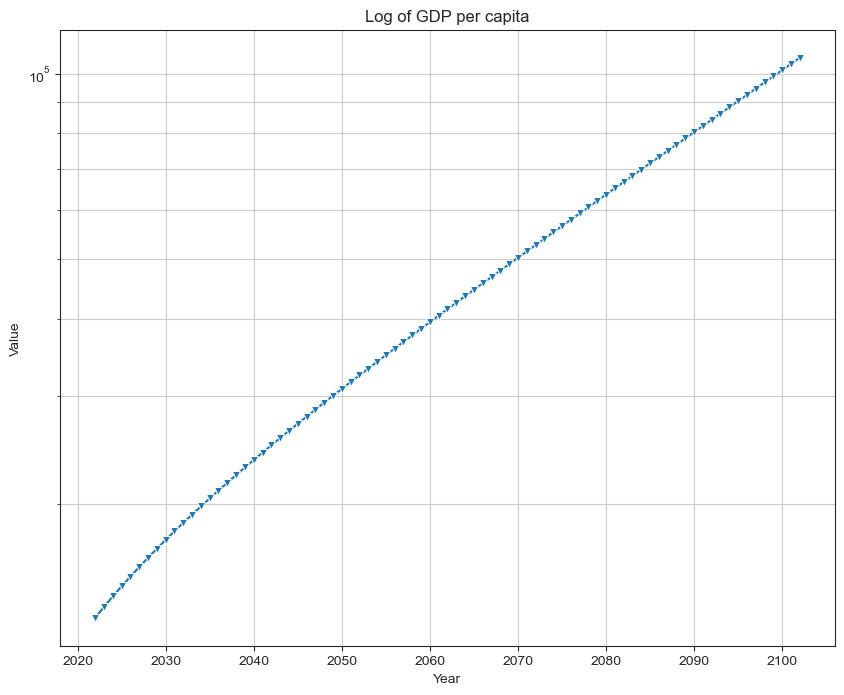

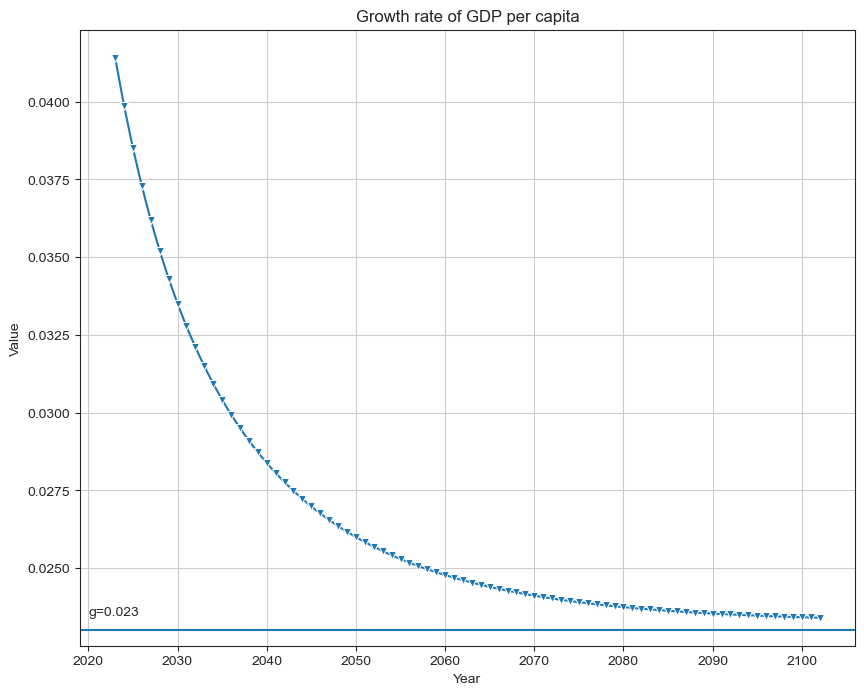

In [40]:
# using the function
capital_accum(scen_1,'A')

# making y, y_tilde and k_tilde cols
cols_of_interest(scen_1,'A','Y','K','y','y_tilde','k_tilde')

# adding a growth rate column
growth_rate(scen_1,'y','y_growth')

# making the level graph
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
sns.lineplot(x='Year', y='y',data=scen_1 ,style=1, markers='v', legend=None).set(yscale='log', title='Log of GDP per capita', ylabel='Value')
ax.grid(True, 'both')

# saving the figure 
# fig.savefig(fname='log_gdp_scen_1.png')

# making the growth graph
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
sns.lineplot(x='Year',y='y_growth', data=scen_1 ,style=1, markers='v',legend=None)
ax.grid(True)
ax.axhline(y=0.023)
ax.annotate('g=0.023', xy=(2020,0.0235))
ax.set(title='Growth rate of GDP per capita', ylabel='Value')

# saving the figure 
# fig.savefig(fname='gdp_growth_scen_1.png')

In [30]:
# scenario 2 - expected random events

# again adding technology but this time with the twist

# extra parameters
theta_A = 0.0025
omega = 4

# initialize empty list to store the A vals
expected_A_list=[]

# iterate over the index, create values of L
for i, row in df_base.iterrows():
    if i == 0:
        expected_A_list.append(A_0)
    else: 
        expected_A_list.append(expected_A_list[i-1] * np.exp(g-theta_A*omega))

# create the scenario dataframe and the A column 
scen_2 = df_base.copy()
scen_2['exp_A'] = expected_A_list

# running the function
capital_accum(scen_2,'exp_A')

# renaming the variables to reflect the expectation
scen_2 = scen_2.rename(columns={'K':'exp_K','Y':'exp_Y'})


# making y, y_tilde and k_tilde cols
cols_of_interest(scen_2,'exp_A','exp_Y','exp_K','exp_y','exp_y_tilde','exp_k_tilde')

# adding a growth rate column
growth_rate(scen_2, 'exp_y', 'exp_y_growth')

# scen_2

In [31]:
# scenario 2 - random events from data

# I just copied in one of the events because I can't load in the spreadsheet somehow
rand_events = pd.DataFrame({'Year':list(range(2022,2103,1)), 
                        'events1':[0,0,6,4,1,6,5,2,4,5,7,3,6,4,7,1,3,6,3,3,3,6,4,5,5,7,6,3,4,4,3,3,4,6,5,3,4,2,5,0,0,4,3,5,5,
                                   6,6,2,1,2,5,5,4,8,5,2,6,2,5,2,4,4,2,6,4,2,3,5,3,6,3,2,5,4,4,2,5,4,8,6,4]})


# merging the dataframes conditional no the events being already in the df (otherwise it merges every time this is run)
if 'events1' in list(scen_2.columns) :
    pass
else:
    scen_2 = scen_2.merge(rand_events,on='Year')
    
    


# technology using the random events

# initialize empty list to store the A vals
rand_A_list=[]

# iterate over the index, create values of L
for i, row in scen_2.iterrows():
    if i == 0:
        rand_A_list.append(A_0)
    else: 
        rand_A_list.append(rand_A_list[i-1] * np.exp(g-(theta_A*row['events1'])))

# adding the col
scen_2['rand_A'] = rand_A_list

# running the function:
capital_accum(scen_2,'rand_A')

# again renaming
scen_2 = scen_2.rename(columns={'K':'rand_K','Y':'rand_Y'})

# making the columns
cols_of_interest(scen_2,'rand_A','rand_Y','rand_K','rand_y','rand_y_tilde','rand_k_tilde')

# growth rate
growth_rate(scen_2,'rand_y','rand_y_growth')
scen_2

,Year,L,exp_A,exp_K,exp_Y,exp_y,exp_y_growth,events1,rand_A,rand_K,rand_Y,rand_y,rand_y_growth
0,2022,45.000000,9900.000000,1.035000e+06,5.883805e+05,13075.122495,NaN,0,9900.000000,1.035000e+06,5.883805e+05,13075.122495,NaN
1,2023,46.370454,10029.540187,1.151045e+06,6.271919e+05,13525.680245,0.034459,0,10130.338742,1.151045e+06,6.314082e+05,13616.606565,0.041413
2,2024,47.782645,10160.775390,1.273312e+06,6.673912e+05,13967.230401,0.032645,6,10211.706488,1.274366e+06,6.698136e+05,14017.926406,0.029473
3,2025,49.237843,10293.727788,1.401960e+06,7.090662e+05,14400.839037,0.031045,4,10345.325313,1.403588e+06,7.117181e+05,14454.697768,0.031158
4,2026,50.737358,10428.419851,1.537168e+06,7.523053e+05,14827.442418,0.029624,1,10559.593225,1.539410e+06,7.589973e+05,14959.337439,0.034912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2098,439.950618,26589.988085,7.078587e+07,2.118967e+07,48163.742703,0.013387,5,26857.221908,7.091479e+07,2.134493e+07,48516.647188,0.011872
77,2099,453.349109,26937.914552,7.395971e+07,2.212698e+07,48807.826203,0.013373,4,27208.645094,7.412358e+07,2.229201e+07,49171.835958,0.013504
78,2100,467.155645,27290.393591,7.727267e+07,2.310545e+07,49459.848604,0.013359,8,27290.393591,7.747287e+07,2.312519e+07,49502.100172,0.006717
79,2101,481.382653,27647.484771,8.073085e+07,2.412687e+07,50119.931186,0.013346,6,27509.592365,8.092998e+07,2.406573e+07,49992.937742,0.009915


In [32]:
# scenario 3

# new value for theta
theta_A_2 = 0.005

# initialize empty list to store the A vals
expected_A_list_2=[]

# iterate over the index, create values of L
for i, row in df_base.iterrows():
    if i == 0:
        expected_A_list_2.append(A_0)
    else: 
        expected_A_list_2.append(expected_A_list_2[i-1] * np.exp(g-theta_A_2*omega))

# making the df
scen_3 = df_base.copy()
scen_3['exp_A'] = expected_A_list_2

capital_accum(scen_3,'exp_A')

# renaming the variables to reflect the expectation
scen_3 = scen_3.rename(columns={'K':'exp_K','Y':'exp_Y'})

# making y, y_tilde and k_tilde cols
cols_of_interest(scen_3,'exp_A','exp_Y','exp_K','exp_y','exp_y_tilde','exp_k_tilde')

# adding a growth rate column
growth_rate(scen_3, 'exp_y', 'exp_y_growth')


In [33]:
# scen 3 - realizations

# merging the dataframes conditional no the events being already in the df (otherwise it merges every time this is run)
if 'events1' in list(scen_3.columns) :
    pass
else:
    scen_3 = scen_3.merge(rand_events,on='Year')
    

# initialize empty list to store the A vals
rand_A_list_2=[]

# iterate over the index, create values of L
for i, row in scen_3.iterrows():
    if i == 0:
        rand_A_list_2.append(A_0)
    else: 
        rand_A_list_2.append(rand_A_list_2[i-1] * np.exp(g-(theta_A_2*row['events1'])))

# adding the col
scen_3['rand_A'] = rand_A_list_2

# running the function:
capital_accum(scen_3,'rand_A')

# again renaming
scen_3 = scen_3.rename(columns={'K':'rand_K','Y':'rand_Y'})

# making the columns
cols_of_interest(scen_3,'rand_A','rand_Y','rand_K','rand_y','rand_y_tilde','rand_k_tilde')

# growth rate
growth_rate(scen_3,'rand_y','rand_y_growth')
scen_3

,Year,L,exp_A,exp_K,exp_Y,exp_y,exp_y_growth,events1,rand_A,rand_K,rand_Y,rand_y,rand_y_growth
0,2022,45.000000,9900.000000,1.035000e+06,5.883805e+05,13075.122495,NaN,0,9900.000000,1.035000e+06,5.883805e+05,13075.122495,NaN
1,2023,46.370454,9929.744595,1.151045e+06,6.230038e+05,13435.361094,0.027551,0,10130.338742,1.151045e+06,6.314082e+05,13616.606565,0.041413
2,2024,47.782645,9959.578557,1.272265e+06,6.583291e+05,13777.577227,0.025471,6,10059.673986,1.274366e+06,6.631157e+05,13877.751803,0.019178
3,2025,49.237843,9989.502156,1.398679e+06,6.944191e+05,14103.362330,0.023646,4,10089.898321,1.401914e+06,6.996205e+05,14208.999655,0.023869
4,2026,50.737358,10019.515660,1.530323e+06,7.313334e+05,14414.101807,0.022033,1,10273.160906,1.534761e+06,7.443975e+05,14671.585337,0.032556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2098,439.950618,12435.244722,4.082353e+07,1.061939e+07,24137.683202,0.003500,5,12686.453329,4.093402e+07,1.077225e+07,24485.134217,0.000470
77,2099,453.349109,12472.606471,4.225367e+07,1.098086e+07,24221.653385,0.003479,4,12724.569835,4.239906e+07,1.114162e+07,24576.250050,0.003721
78,2100,467.155645,12510.080473,4.373128e+07,1.135442e+07,24305.432173,0.003459,8,12510.080473,4.391249e+07,1.136993e+07,24338.623088,-0.009669
79,2101,481.382653,12547.667066,4.525794e+07,1.174046e+07,24389.036389,0.003440,6,12422.815693,4.543760e+07,1.167732e+07,24257.869390,-0.003318


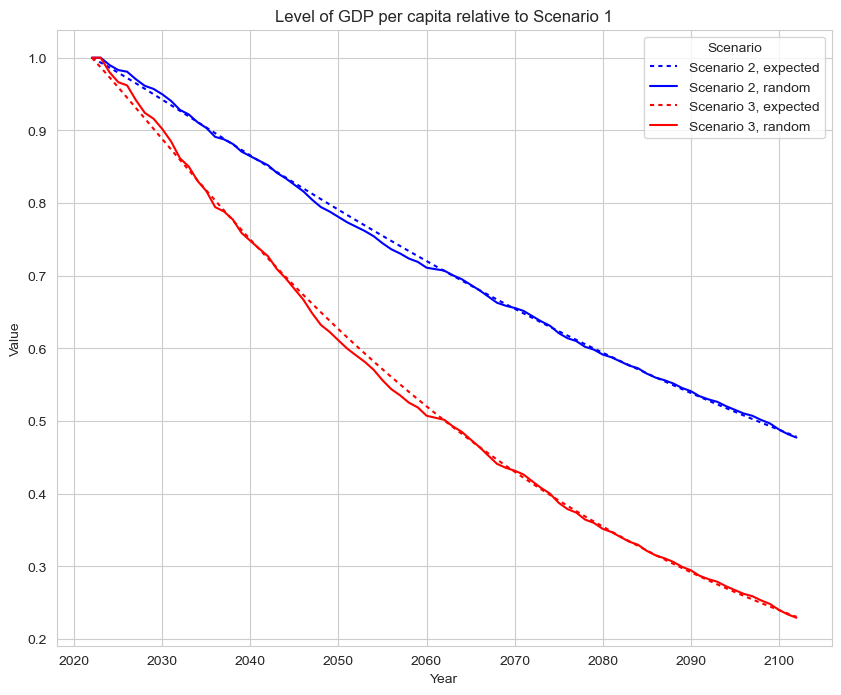

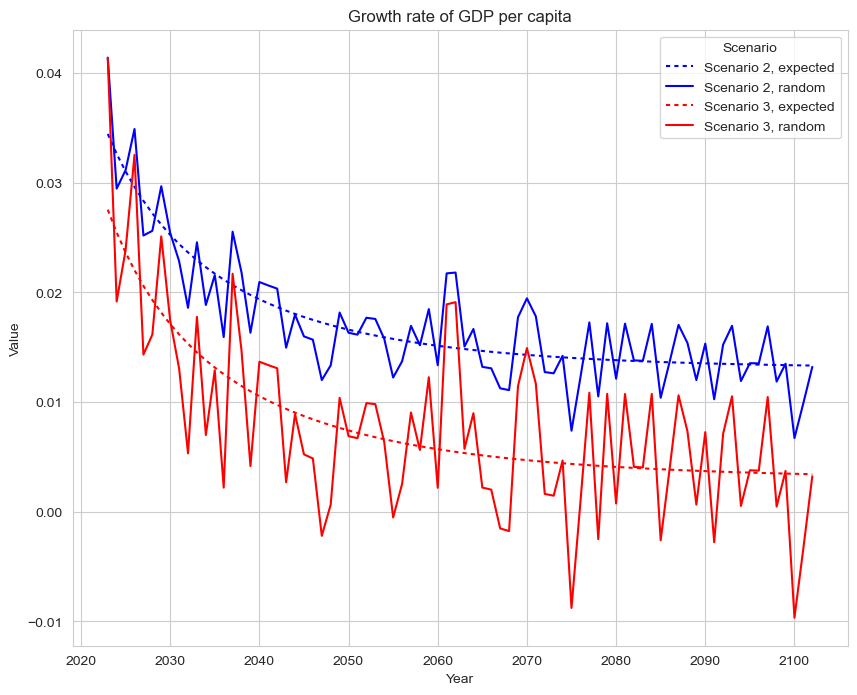

In [41]:
# comparisons across scenarios
comparison = df_base.copy()
comparison = comparison.drop(['L'], axis=1)
# making the relevant columns
comparison['Scenario 2, expected'] = scen_2['exp_y']/scen_1['y']
comparison['Scenario 2, random'] = scen_2['rand_y']/scen_1['y']
comparison['Scenario 3, expected'] = scen_3['exp_y']/scen_1['y']
comparison['Scenario 3, random'] = scen_3['rand_y']/scen_1['y']


# The relative gdp per capita plot
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
sns.lineplot(data=pd.melt(comparison, ['Year']), x='Year', y='value',
             hue='variable',  palette=['b','b','r','r'], style='variable', dashes=[(2,2),'',(2,2),'']).set(title='Level of GDP per capita relative to Scenario 1', ylabel='Value')
plt.legend(title='Scenario')

# saving the figure 
# fig.savefig(fname='gdp_rel.png')

# The growth rate plot
growth_rates = pd.DataFrame({'Year':list(range(2022,2103,1)),
                             'Scenario 2, expected':scen_2['exp_y_growth'],
                             'Scenario 2, random':scen_2['rand_y_growth'],
                             'Scenario 3, expected':scen_3['exp_y_growth'],
                             'Scenario 3, random':scen_3['rand_y_growth']})

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(8)
sns.lineplot(data=pd.melt(growth_rates, ['Year']), x='Year', y='value',
             hue='variable', palette=['b','b','r','r'], style='variable', dashes=[(2,2),'',(2,2),'']).set(title='Growth rate of GDP per capita', ylabel='Value')
plt.legend(title='Scenario')

# saving the figure 
# fig.savefig(fname='growth_comparison.png')


In [44]:
# uncomment if you want to actually write to it

# # exporting the data to excel
# import openpyxl 

# # writing the data to a new file because the one provided is formatted in such a way that it throws me an error when trying to write to it 
# # will just copy the results to the destination file afterwards

# # creating a file in the same directory with a sheet called 'Data'
# workbook = openpyxl.Workbook()

# wb_sheet = workbook['Sheet']
# wb_sheet.title = 'Data'

# fil_dir = 'writing_file.xlsx'
# workbook.save(fil_dir)

# # writing the dataframes to the file
# writer = pd.ExcelWriter(fil_dir, engine='openpyxl', mode='a', if_sheet_exists='overlay')

# df_base.to_excel(writer, sheet_name='Data', startcol=0)
# scen_1.to_excel(writer, sheet_name='Data', startcol=4, index=False)
# scen_2.to_excel(writer, sheet_name='Data', startcol=12, index=False)
# scen_3.to_excel(writer, sheet_name='Data', startcol=26, index=False)
# comparison.to_excel(writer, sheet_name='Data', startcol=40, index=False)
# growth_rates.to_excel(writer, sheet_name='Data', startcol=46, index=False)

# writer.close()